<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [34]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import datetime
from keras.applications import vgg16, resnet, xception, inception_v3
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, ConfusionMatrixDisplay,confusion_matrix, recall_score,precision_score,f1_score,accuracy_score,roc_auc_score,multilabel_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.feature import hog
from sklearn.cluster import KMeans, SpectralClustering,AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from scipy.cluster.hierarchy import ward, fcluster, dendrogram, linkage
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import json


import shutil

IMG_SIZE = 120

# Función para añadir datos a una tebla de excel
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n
        
        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)

def get_base_model(name):
    if name == 'vgg':
        return vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    elif name == 'inception':
        return inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    elif name == 'xception':
        return xception.Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    else: return resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

def preprocess_data(name, x):
    if name == 'vgg':
        return vgg16.preprocess_input(x)
    elif name == 'inception':
        return inception_v3.preprocess_input(x)
    elif name == 'xception':
        return xception.preprocess_input(x)
    else: return resnet.preprocess_input(x)

%store -r scoring


In [36]:
def image_feature(names, path):
    model = get_base_model(model_name)
    features = []
    img_name = []
    for name in tqdm(names):
        fname = path +'/'+ name
        img = image.load_img(fname,target_size=(IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        x = np.expand_dims(x,axis=0)
        feat = model.predict(x)
        feat = feat.flatten()
        features.append(feat)
        img_name.append(name)
    return features,img_name

def hog_feature(names, path):
    orient = 8
    ppc = 8
    cpb = 3
    features = []
    img_name = []
    for name in tqdm(names):
        fname = path +'/'+ name
        img = image.load_img(fname,target_size=(IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        fd = hog(x, orientations=orient, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(cpb, cpb), channel_axis=2)
        feat = fd.flatten()
        features.append(feat)
        img_name.append(name)
    return features,img_name

def rgb_feature(names, path):
    features = []
    img_name = []
    for name in tqdm(names):
        fname=path +'/'+ name
        img=image.load_img(fname,target_size=(IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        x = np.expand_dims(x,axis=0)
        feat = x.flatten()
        features.append(feat)
        img_name.append(name)
    return features,img_name

def pca_feature(names, path):
    img_name = []
    X = []
    for name in tqdm(names):
        fname = path +'/'+ name
        img = image.load_img(fname,target_size=(IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        X.append(x.flatten())
        img_name.append(name)
    
    pca = PCA(n_components = min(len(X), len(X[0]))-1)
    pca_features = pca.fit_transform(X)
    return pca_features,img_name

def save_to_folder():
    # Made folder to seperate images
    clusterI_path = "./Dataset/Grading_dataset/cluster I"
    clusterII_path = "./Dataset/Grading_dataset/cluster II"
    clusterIII_path = "./Dataset/Grading_dataset/cluster III"
    # Images will be seperated according to cluster they belong
    for i in range(len(image_cluster)):
        if image_cluster['clusterid'][i]==0:
            shutil.copy(os.path.join(input_cluster_path, image_cluster['image'][i]), clusterI_path)
        elif image_cluster['clusterid'][i]==1:
            shutil.copy(os.path.join(input_cluster_path, image_cluster['image'][i]), clusterII_path)
        else:
            shutil.copy(os.path.join(input_cluster_path, image_cluster['image'][i]), clusterIII_path)

#### Lectura de los datos:

In [45]:
# Function to Extract features from the images
model_name = 'spectral'
multiprocess = False

# Leer los nombres de las imágenes para importarlas
input_cluster_path = "./Dataset/Grading_dataset/Cluster"
_names = os.listdir(input_cluster_path)

tic = time.perf_counter()
if model_name == 'rgb':
    img_features,img_name = rgb_feature(_names, input_cluster_path)
elif model_name == 'hog':
    img_features,img_name = hog_feature(_names, input_cluster_path)
elif model_name == 'pca':
    img_features,img_name = pca_feature(_names, input_cluster_path)
else:
    img_features,img_name = image_feature(_names, input_cluster_path)

cluster_method = "decision_tree"
k = 3
#Creating Clusters
if cluster_method == "kmeans":
    clusters = KMeans(k, random_state = 42)
    param_grid = {
    "init":["k-means++", "random"],
    "algorithm":["auto", "full", "elkan"],
    "n_clusters":[3]     
    }
    
    search = GridSearchCV(estimator = clusters, param_grid =param_grid, n_jobs=-1,scoring=scoring,refit=False)
    results = search.fit(img_features)
    params = results.cv_results_["params"]
    df = pd.DataFrame.from_dict(results.cv_results_)
    df.to_excel("./informe/tables/parameters_clustering_kmeans.xlsx") 
    Clases=['Clase extra','Clase I','Clase II']
    data_recall =[]
    data_precision = []
    data_f1 =[]
    data_accuracy = []
    data_roc_auc  =[]
    t = np.concatenate((np.ones(200), 2 * np.ones(200), np.zeros(200)), axis = 0)
    for param in params:
        clustering= KMeans(**param)
        clustering.fit(img_features)
        y_pred=clustering.labels_
        data_recall.append(recall_score(t,y_pred,average="macro"))
        data_precision.append(precision_score(t,y_pred,average="macro"))
        data_f1.append(f1_score(t,y_pred,average="macro"))
        data_accuracy.append(accuracy_score(t,y_pred))

elif cluster_method == "decision_tree":
    
    clustering = AgglomerativeClustering(n_clusters=3,linkage="single")
    param_grid = {
    "affinity":["euclidean", "l1", "l2", "manhattan", "cosine"],
    "linkage":["complete","average","single"], 
    "n_clusters":[3]     
    }
    search = GridSearchCV(estimator = clustering, param_grid =param_grid, n_jobs=-1,scoring=scoring,refit=False)
    results = search.fit(img_features)
    params = results.cv_results_["params"]
    df = pd.DataFrame.from_dict(results.cv_results_)
    df.to_excel("./informe/tables/parameters_clustering_tree.xlsx") 
    Clases=['Clase extra','Clase I','Clase II']
    data_recall =[]
    data_precision = []
    data_f1 =[]
    data_accuracy = []
    data_roc_auc  =[]
    t = np.concatenate((np.ones(200), 2 * np.ones(200), np.zeros(200)), axis = 0)
    for param in params:
        clustering=AgglomerativeClustering(**param)
        clustering.fit(img_features)
        y_pred=clustering.labels_
        data_recall.append(recall_score(t,y_pred,average="macro"))
        data_precision.append(precision_score(t,y_pred,average="macro"))
        data_f1.append(f1_score(t,y_pred,average="macro"))
        data_accuracy.append(accuracy_score(t,y_pred))
   
elif cluster_method == "spectral":
    clustering = SpectralClustering(n_clusters=3,eigen_solver="arpack",affinity="nearest_neighbors")
    param_grid = {
    "eigen_solver":["arpack", "lobpcg", "amg"],
    "assign_labels":["kmeans","discretize"], 
    "n_clusters":[3]     
    }
    search = GridSearchCV(estimator = clustering, param_grid =param_grid, n_jobs=-1,scoring=scoring,refit=False)
    results = search.fit(img_features)
    params = results.cv_results_["params"]
    df = pd.DataFrame.from_dict(results.cv_results_)
    df.to_excel("./informe/tables/parameters_clustering_spectral.xlsx") 
    Clases=['Clase extra','Clase I','Clase II']
    data_recall =[]
    data_precision = []
    data_f1 =[]
    data_accuracy = []
    data_roc_auc  =[]
    t = np.concatenate((np.ones(200), 2 * np.ones(200), np.zeros(200)), axis = 0)
    for param in params:
        clustering=SpectralClustering(**param)
        clustering.fit(img_features)
        y_pred=clustering.labels_
        data_recall.append(recall_score(t,y_pred,average="macro"))
        data_precision.append(precision_score(t,y_pred,average="macro"))
        data_f1.append(f1_score(t,y_pred,average="macro"))
        data_accuracy.append(accuracy_score(t,y_pred))


  

# Clases=['Clase I','Clase II','Clase extra']
# accuracy = round(accuracy_score(t,y),2)
# print(round(accuracy_score(t,y),2))
# cm = confusion_matrix(t, y)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Clases)
# disp.plot()


100%|██████████| 600/600 [01:06<00:00,  8.99it/s]
c:\Python38\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


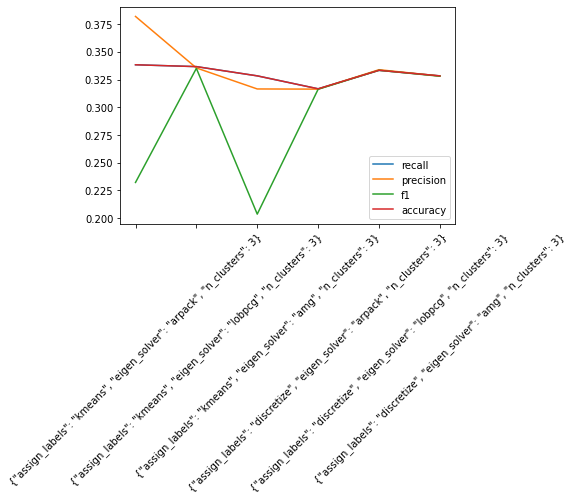

In [42]:
labels = []
for param in params:
    labels.append(json.dumps(param))
plt.plot(labels, data_recall, label = "recall",)
plt.plot(labels, data_precision, label = "precision")
plt.plot(labels, data_f1, label = "f1")
plt.plot(labels, data_accuracy, label = "accuracy")
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Entrenamientofinal y resultado

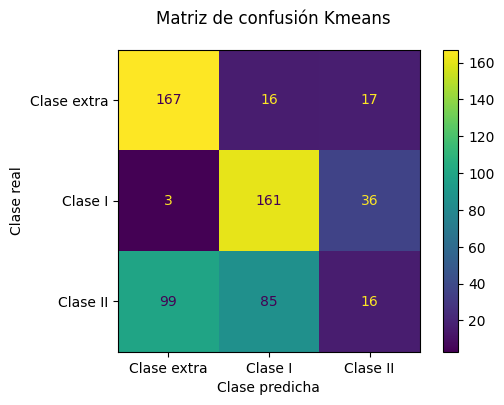

In [46]:
#Entrenamiento con modelo final y resultados
Clases=['Clase extra','Clase I','Clase II']
if cluster_method == "kmeans":
    clustering = KMeans(n_clusters=3,algorithm="full",init="random")
    clustering.fit(img_features)
    y_pred=clustering.labels_
    disp = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred,y_true=t,display_labels=Clases)
    disp.figure_.suptitle("Matriz de confusión Kmeans")                                           # Añade un título a la figura de la matriz de confusión
    disp.figure_.set_dpi(100)                                                                                  # Establece el tamaño de la figura
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")

elif cluster_method == "spectral":
    clustering=SpectralClustering(n_clusters=3,assign_labels="discretize",eigen_solver="lobpcg")
    clustering.fit(img_features)
    y_pred=clustering.labels_
    disp = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred,y_true=t,display_labels=Clases)
    disp.figure_.suptitle("Matriz de confusión Spectral clustering ")                                           # Añade un título a la figura de la matriz de confusión
    disp.figure_.set_dpi(100)                                                                                  # Establece el tamaño de la figura
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
elif cluster_method == "decision_tree":
    clustering=AgglomerativeClustering(n_clusters=3,linkage="complete",affinity="manhattan")
    clustering.fit(img_features)
    y_pred=clustering.labels_
    disp = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred,y_true=t,display_labels=Clases)
    disp.figure_.suptitle("Matriz de confusión Decision tree")                                           # Añade un título a la figura de la matriz de confusión
    disp.figure_.set_dpi(100)                                                                                  # Establece el tamaño de la figura
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")


In [47]:
mcm = multilabel_confusion_matrix(t, y_pred)
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]

specificity_score = tn / (tn + fp)

print("recall: "+str(recall_score(t,y_pred,average='macro')))
print("precission:"+str(precision_score(t,y_pred,average='macro')))
print("f1:"+str(f1_score(t,y_pred,average='macro')))
print("accuracy:"+str(accuracy_score(t,y_pred)))    
# print("roc_auc:"+str(roc_auc_score(t,clustering.predict_proba(x_val),multi_class='ovr')))
print("specificity: "+ str(np.mean(specificity_score)))

recall: 0.5733333333333334
precission:0.48906857287702615
f1:0.5093607743000186
accuracy:0.5733333333333334
specificity: 0.7866666666666667
